In [2]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize models
llm = ChatOpenAI(model="gpt-4.1", temperature=0)
embeddings = OpenAIEmbeddings()

In [5]:
llm

ChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000024D02E244A0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000024D0FB71040>, root_client=<openai.OpenAI object at 0x0000024D01A20E30>, root_async_client=<openai.AsyncOpenAI object at 0x0000024D0F6F9430>, model_name='gpt-4.1', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [6]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [8]:
### Sample Docuemnt And VectorStore
# Sample documents for demonstration
sample_texts = [
    "LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.",
    "RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.",
    "Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.",
    "Agentic systems are AI systems that can take actions, make decisions, and interact with their environment autonomously. They often use planning and reasoning capabilities."
]

documents=[Document(page_content=text) for text in sample_texts]

##create vector store
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k=3)

In [9]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]
    
    # Simple heuristic: if question contains certain keywords, retrieve
    retrieval_keywords = ["what", "how", "explain", "describe", "tell me"]
    needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)
    
    return {**state, "needs_retrieval": needs_retrieval}

In [10]:
def retrieve_documents(state: AgentState) -> AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {**state, "documents": documents}

In [11]:
def generate_answer(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    documents = state.get("documents", [])
    
    if documents:
        # RAG approach: use documents as context
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {question}

Answer:"""
    else:
        # Direct response without retrieval
        prompt = f"Answer the following question: {question}"
    
    response = llm.invoke(prompt)
    answer = response.content
    
    return {**state, "answer": answer}

In [12]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

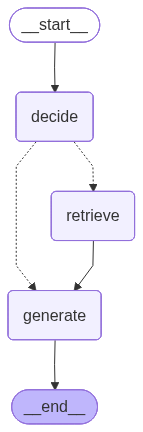

In [13]:
# Create the state graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

# Set entry point
workflow.set_entry_point("decide")

# Add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

# Add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()
app

In [14]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }
    
    result = app.invoke(initial_state)
    return result

In [15]:
# Test with a question that should trigger retrieval
question1 = "Who is Shees Ikram?"
result1 = ask_question(question1)
result1

{'question': 'Who is Shees Ikram?',
 'documents': [],
 'answer': 'Shees Ikram is a Pakistani child actor best known for his role as Roomi in the popular television drama "Mere Paas Tum Ho." His performance as the son of the lead characters, played by Humayun Saeed and Ayeza Khan, received widespread acclaim and made him a well-recognized face in the Pakistani entertainment industry.',
 'needs_retrieval': False}

In [16]:
# Test with another question
question2 = "How does RAG work?"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "="*50 + "\n")

Question: How does RAG work?
Retrieved documents: 4
Answer: RAG (Retrieval-Augmented Generation) works by combining information retrieval with text generation to produce more accurate and contextually relevant responses. Here’s how it works:

1. **Retrieval Step:** When a user asks a question, the system first retrieves relevant documents or passages from a large collection of data. This is often done using a vector database, which stores documents as high-dimensional vectors and enables efficient similarity search based on the semantic meaning of the query.

2. **Augmentation Step:** The retrieved documents are then provided as additional context to a language model (such as an LLM).

3. **Generation Step:** The language model uses both the user’s question and the retrieved context to generate a final answer. This allows the model to ground its response in factual information from the retrieved documents, improving accuracy and reducing hallucinations.

In summary, RAG systems enhance